# Aufgabe 4
**Problem Description:**
Gegeben ist ein Warenbestand mit verschiedenen Items in unterschiedlichen Stückzahlen. Ziel dieser Aufgabe ist es, eine Menge von Verkaufsgeboten so zu definieren, dass der gesamte Verkaufserlös maximiert wird. Ein Verkaufsgebot wird definiert durch einen Ort (stationsid), ein Datum, ein Item, die zu verkaufende Stückzahl und einen Stückpreis. Es dürfen beliebig viele Verkaufsgebote an beliebig vielen Orten eingestellt werden. Verkaufsgebote sind nur an dem Tag und in der Station gültig für die sie definiert wurden.

Verkäufe in anderen Stationen werden durch Angebote in regional nahegelegenen Stationen nicht beeinflusst. Gebote sind auch an durch Spieler einnehmbaren Stationen möglich (stationid beginnt mit 61..., siehe PDF “Lies Mich”) und werden regulär bewertet.

Da es keine effiziente Möglichkeit gibt, den Teilnehmern Rückmeldungen zu eventuellen Restbeständen zu geben, verfallen nicht verkaufte Einheiten und stehen für weitere Verkaufsgebote nicht mehr zur Verfügung.

_Die aufsummierte Stückzahl eines Items über alle Verkaufsgebote darf nicht höher als der Warenbestand des Items sein, d.h. zum Monatsbeginn ist der gesamte Warenbestand gegeben und es kommen keine weiteren Stückzahlen hinzu, Leerverkäufe sind nicht erlaubt._

Der zeitliche Rahmen für alle Verkäufe ist der Januar 2016. Als Datengrundlage stehen die Stückzahlen und durchschnittlichen Preise aller Kauf- und Verkaufsgebote sowie der tatsächlichen Verkäufe pro Tag, Item und Station / System bis zum 23.12.2015 zur Verfügung.

####  `TL;DR`
* Predict `(stationid, price, supply, type_id)`
* Time: `2012-01-01`—`2015-12-23`
* Prediction target: `January 2016` with daily granularity
* The total number of supplied products must not exceed the given number of products per month
* No neighbourhood correlation between supply/demand
* Products can be sold independent of the type of user ownable/non-ownable station

## Index
* [Fetching the Data](#Fetching-the-Data)
* [Data Analysis](#Preliminary-Data-Analysis)
    * [How is the Demand Distributed?](#How-is-the-demand-distributed?)
    * [How does the demand per station look like?](#Stations-with-demand-per-product)
    * [User Ownable vs. Non-Ownable Stations](#User-Ownable-vs.-Non-Ownable-Stations)
* [Data Preprocessing](#Data-Preprocessing)

In [1]:
%matplotlib inline
import psycopg2
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp

In [2]:
%load_ext autoreload
%autoreload 2 

In [3]:
sns.set(color_codes=True)

---

### Fetching the Data

In [4]:
# local db
conn = psycopg2.connect("dbname=eveonline user=REPLACE_USER")
cur = conn.cursor()

In [5]:
cur.execute("SELECT count(1) FROM stastations")
N_stations = cur.fetchone()[0]
print(N_stations)

10378


In [6]:
columns = ["typeid", "stationid", "time", "supply",
           "supp_bids", "supp_avg_p", "supp_min_p", "supp_max_p",
           "demand", "dem_bids", "dem_avg_p", "dem_min_p",
           "dem_max_p"]

In [7]:
conn.rollback()

In [7]:
cur.execute("SELECT %s FROM supply_and_demand WHERE typeid = 34" % (', '.join(columns)))
df_snd_tritanium = pd.DataFrame(cur.fetchall(), columns=columns)

In [8]:
cur.execute("SELECT %s FROM supply_and_demand WHERE typeid = 1230" % (', '.join(columns)))
df_snd_veldspar = pd.DataFrame(cur.fetchall(), columns=columns)

In [9]:
cur.execute("SELECT %s FROM supply_and_demand WHERE typeid = 43" % (', '.join(columns)))
df_snd_antibiotics = pd.DataFrame(cur.fetchall(), columns=columns)

In [10]:
cur.execute("SELECT %s FROM supply_and_demand WHERE typeid = 28668" % (', '.join(columns)))
df_snd_nanite = pd.DataFrame(cur.fetchall(), columns=columns)

In [11]:
cur.execute("SELECT %s FROM supply_and_demand WHERE typeid = 29984" % (', '.join(columns)))
df_snd_tengu = pd.DataFrame(cur.fetchall(), columns=columns)

In [12]:
dfs = {
    'tritanium': df_snd_tritanium,
    'veldspar': df_snd_veldspar,
    'antibiotics': df_snd_antibiotics,
    'nanite repair paste': df_snd_nanite,
    'tengu': df_snd_tengu
}

## Exporting Data as CSV

In [35]:
for k in dfs.keys():
    dfs[k].to_csv('../output/df_{0}.csv'.format(k.replace(' ', '_')), index=False)

## Preliminary Data Analysis

In [13]:
from IPython.display import HTML, display

### How is the demand distributed?

In [14]:
df_snd_veldspar['demand']

0           500000.0
1                NaN
2                NaN
3           100000.0
4                NaN
5                NaN
6           100000.0
7           100000.0
8                NaN
9          1000000.0
10               NaN
11               NaN
12        30000000.0
13        30000000.0
14        30000000.0
15        30000000.0
16        30000000.0
17        30000000.0
18        30000000.0
19        30000000.0
20        30000000.0
21        30000000.0
22        30000000.0
23        30000000.0
24        30000000.0
25        30000000.0
26        30000000.0
27        30000000.0
28        30000000.0
29        30000000.0
             ...    
950895     2513283.0
950896     2513229.0
950897     2513205.0
950898     2389381.0
950899     2389331.0
950900     2389149.0
950901     2389045.0
950902     2389045.0
950903     2389045.0
950904     2388947.0
950905     2388797.0
950906     2388736.0
950907     2388728.0
950908     2388680.0
950909     2388616.0
950910     2388529.0
950911     23

In [15]:
df_snd_veldspar.stationid.unique

<bound method Series.unique of 0         60000004
1         60000004
2         60000004
3         60000010
4         60000010
5         60000010
6         60000010
7         60000010
8         60000010
9         60000010
10        60000010
11        60000010
12        60000013
13        60000013
14        60000013
15        60000013
16        60000013
17        60000013
18        60000013
19        60000013
20        60000013
21        60000013
22        60000013
23        60000013
24        60000013
25        60000013
26        60000013
27        60000013
28        60000013
29        60000013
            ...   
950895    61001059
950896    61001059
950897    61001059
950898    61001059
950899    61001059
950900    61001059
950901    61001059
950902    61001059
950903    61001059
950904    61001059
950905    61001059
950906    61001059
950907    61001059
950908    61001059
950909    61001059
950910    61001059
950911    61001059
950912    61001059
950913    61001059
950914    61001059


In [16]:
def demand_for_station(df, stationid):
    return df[(df.stationid == stationid)
       # & (df.supply > 0.0)
       & (df.demand > 0)]

# i.e.
# demand_for_station(df_snd_veldspar, 60000004)

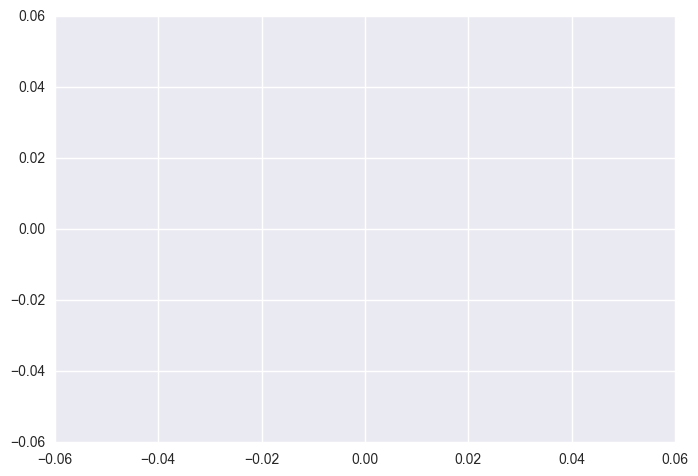

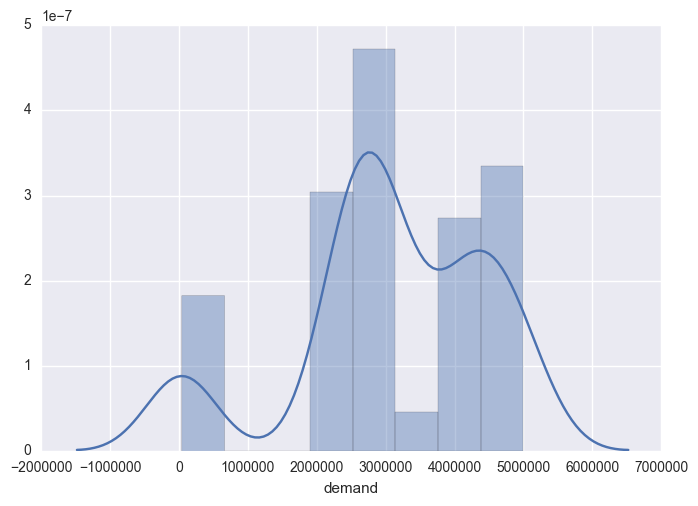

In [25]:
# let's look at two example demand distributions
from scipy.stats import poisson, weibull_min, entropy

d1 = demand_for_station(df_snd_veldspar, 60000004)['demand']
x1 = np.linspace(min(d1), max(d1), 100)

# d1p_hat = poisson.fit(d1)
d1wm_hat = weibull_min.fit(d1)
# sns.distplot(d1)
# sns.plt.plot(x=x1, y=d1p_hat)
sns.plt.plot(x=x1, y=d1wm_hat)
sns.plt.show()

sns.distplot(demand_for_station(df_snd_veldspar, 61001059)['demand'])
sns.plt.plot()
sns.plt.show()

In [ ]:
"""
"""

obs = []

station_no_snd = []
station_snd = []
totals = []

for d in dfs.keys():
    print(d, dfs[d].shape[0])
    df = dfs[d]
    _obs = []

    snd_stations = []
    residuals = []

    for station in df['stationid'].unique():
        snd_for_station = df[(df.stationid == station)
                                   # & (df.supply > 0.0)
                                   & (df.demand > 0.0)]

        _obs.append(len(snd_for_station))

        if len(snd_for_station) > 0:
            snd_stations.append(station)
        else:
            residuals.append(station)

    obs.append(_obs)
    # print("has snd:", len(snd_stations))
    station_snd.append(len(snd_stations))
    # print("has no snd:", len(residuals))
    station_no_snd.append(len(residuals))
    # print('---')

    totals.append(len(snd_stations) + len(residuals))

In [167]:
# TODO:
# * mean supply/demand?
# * what is the normal supply/demand relation?

--- 

### Stations with demand per product

In [168]:
o = "<h3>Stations with demand per product</h3>\n<ol>"
# print("stations with demand per product")
for t, s, r, n in zip(totals, station_snd, station_no_snd, ['tritanium',
                                                     'veldspar',
                                                     'antibiotics',
                                                     'nanite repair paste',
                                                     'tengu']):
    if 7 < len(n) < 15:
        t = "\t\t"
    elif 7 > len(n):
        t = "\t\t\t"
    else:
        t = "\t"

    # print("{0}:{1} {2:.4f}%  ({3})".format(n, t, (s / (s + r)), (s+r)))
    o += "<li><em>{0}:</em><code>{1} {2:.4f}%  ({3})</code></li>".format(n, t, (s / (s + r)), (s+r))
    
o += "</ol>"
display(HTML(o))

---

### User Ownable vs. Non-Ownable Stations
Stations with `61` as a prefix are user ownable, others are not.

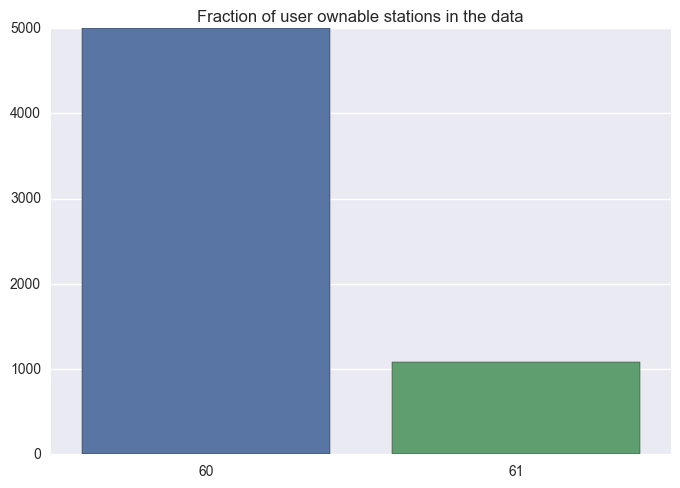

In [117]:
station_types = []

for s in df_snd_tritanium['stationid'].unique():
    station_types.append(int(s * 0.000001))

st = np.array(station_types)
p = sns.barplot(x=[60, 61],
                y=[len(np.where(st == 60)[0]),
                   len(np.where(st == 61)[0])])
_ = p.set_title('Fraction of user ownable stations in the data')

---

## Data Preprocessing

In [47]:
"""
Creates a full list of dates to use as features.

The data frames are "sparse" such that only dates with
data are contained, and thus some of the dates could be
missing, but which must be accounted for.
"""
import datetime as dt

start_date = pd.to_datetime("2012-01-01")
end_date = pd.to_datetime("2015-12-23")

d = []

# number of days between the end and start date
days = (end_date - start_date).days

for day in range(days):
    d.append((start_date + dt.timedelta(day)))

date_index = pd.to_datetime(d)

# create lookup fn for index of date in feature vector
def date_lookup(date):
    return d.index(date)

# i.e.
# date_lookup(pd.to_datetime('2013-10-14'))

## Date Imputation

In [ ]:
# takes ages. be careful. plan for at least 24h.
from tqdm import tqdm
imputed_dfs = {}

for k in dfs.keys():
    stations = dfs[k]['stationid'].unique()
    
    missing = []

    pre_n = dfs[k].shape[0]

    for s in tqdm(stations):
        df_station = dfs[k][dfs[k]['stationid'] == s]
        times = df_station['time'].unique()
        
        for d in ds:
            if d not in times:
                missing.append({
                    'time': d,
                    'stationid': s
                })

    imputed_dfs[k] = dfs[k].append(missing, ignore_index=True)

    assert imputed_dfs[k].shape[0] > pre_n, "nothing was appended"

    print("{0} done".format(k))
    print("imputed {0}".format(imputed_dfs[k].shape[0] - pre_n))

In [ ]:
# takes ages. longer than the cell before.
import itertools

# validate imputation
for k in imputed_dfs.keys():
    # two things:
    # 1. for all stations, dates there must be a tuple (station, date)
    #    for all products
    # 2. this tuple has to be unique
    df = imputed_dfs[k]
    dates = df['time'].unique()
    stations = df['stationid'].unique()

    print('-------\n{0}'.format(k))
    print('unique dates:\t\t{0}'.format(len(dates)))
    print('unique stations:\t{0}'.format(len(stations)))
    
    for c in itertools.product(ds, stations):
        d, s = c
        data = df[(df['stationid'] == s) & (df['time'] == d)]
        assert data.shape[0] > 0, "{0} is missing {1} on {2}".format(k, s, d)

In [ ]:
for k in dfs.keys():
    imputed_dfs[k].to_csv('../output/df_{0}_imputed.csv'.format(k.replace(' ', '_')), index=False)

---

### Data Preprocessing

In [172]:
o = "<ul>"
for c in df_snd_tengu.columns.tolist():
    o += "<li>{0}</li>".format(c)
    
display(HTML(o))

In [ ]:
feature_names = []  # TODO!

In [57]:
def make_features_for_station(df, station_id):
    snd_s = df[df['stationid'] == station_id].fillna(0)

    m = 5                 # no of features
    y_demand = [0] * days
    y_price = [0] * days
    X = [[]] * days       # TODO: how many features?

    for i, row in snd_s.iterrows():
        j = date_lookup(row['time'])

        # regression target
        y_demand[j] = row['demand']
        y_price[j] = row['avg_']  # TODO

        prev_demand = np.sum(y_dem)
        prev_avg_p = np.sum(y_aprice)
        prev_demand_cnt = np.count_nonzero(y_dem)
        # if the station is ownable by the user, then the id
        # starts with `61`
        is_ownable = int(station_id * 0.000001) == 61

        # previous week, if any
        X[j] = None # TODO

    return (X, y)

In [258]:
def make_features(df):
    import datetime as dt

    X = []
    nulls = []

    stations = list(map(int, df['stationid'].values))
    demand = []
    N = print(date_index.shape[0])

    for station in stations:
        x = make_features_for_station(df, station)

        if x is None:
            nulls.append(station)
        else:
            X.append(x)

    return (date_index, X, nulls)

make_features(df_snd_tengu)

1452


## DNN
pred. $\hat{y}^{(i)}$, where $i$ are the products, train net. per station

Let $m$ be the number of features, $j$ the $j$-th station, $X^{(j)} \in \mathbb{R}^{m \times n}$

## Regression Trees

In [157]:
from sklearn import tree

clf = tree.DecisionTreeRegressor()

In [ ]:
X = 

In [ ]:
Y = 

## Unused

## Background
Consider a price-dependent demand estimation. Let $q$ be the stocking quantity and $p$ be the price.
The demand then is defined as $D(p, \epsilon) = y(p) + \epsilon$, where $\epsilon$ is a random variable and $y(p)$ a decreasing function that captures the price-demand dependency. Furthermore, let $F(\cdot)$ be the cumulative distribution function of $\epsilon$, $f(\cdot)$ the pdf.

## Station Embeddings
1. regions: 200
2. constellations: 2240
3. solar systems: 16070

Let $s_{r_{c_j}} = s_j$ be a solarsystem in region number $r$, constellation number $c$,  $j, r, c \in \mathbb{R}$.
$\epsilon \in \mathbb{R}$ shall be the neighbourhood radius, $\mathcal{N_\epsilon}(s_j)$ then is the neighbourhood of solar system $s_j$ given the neighbourhood radius $\epsilon$.

$$P(s_j|s_i) = \frac{1}{\epsilon}\delta(s_j,s_i)$$


### Neighbourhood-by-Solarsystem Embedding
*NbS* models the prob. distribution of $P(\mathcal{N_\epsilon}(s_j)|s_j)$.


### Solarsystem-by-Neighbourhood Embedding
SbN models the prob. distribution $P(s_j|\mathcal{N_\epsilon}(s_j))$.



remaining:

* embedding with weighted supply/demand for some/all of the five products, where the expected trade is modelled by weighting supply and demand.
* neighbourhood dependent on the constellation/region
* penalizing on the prob. dist. of systems in the neighbourhood from another constellation (or custom objection function)
* weighting w/ gaussian prior weighted by distance?

In [26]:
cur.execute("""
    SELECT constellationid, stationid, stationtypeid,
        corporationid, solarsystemid, security, regionid,
        stationname, x, y, z
    FROM stastations
""")

In [27]:
sts = cur.fetchall()
df_st = pd.DataFrame(sts,
                     columns=['constellationid', 'stationid', 'stationtypeid',
        'corporationid', 'solarsystemid', 'security', 'regionid',
        'stationname', 'x', 'y', 'z'])

In [20]:
import keras
from keras.models import Model
from keras.layers.core import Dense, Reshape, Lambda
from keras.layers import Input, Embedding, merge
from keras import backend as K

Using TensorFlow backend.
